In [1]:
import tiled_fuzzer
import codegen
import pindef
import bslib
import chipdb
import fuse_h4x
import gowin_unpack
from wirenames import wirenames
from PIL import Image
import numpy as np
import pickle

def dff(mod, cst, row, col, clk=None):
    "make a dff with optional clock"
    name = tiled_fuzzer.make_name("DFF", "DFF")
    dff = codegen.Primitive("DFF", name)
    dff.portmap['CLK'] = clk if clk else name+"_CLK"
    dff.portmap['D'] = name+"_D"
    dff.portmap['Q'] = name+"_Q"
    mod.wires.update(dff.portmap.values())
    mod.primitives[name] = dff
    cst.cells[name] = f"R{row}C{col}"
    return dff.portmap['CLK']

def ibuf(mod, cst, loc, clk=None):
    "make an ibuf with optional clock"
    name = tiled_fuzzer.make_name("IOB", "IBUF")
    iob = codegen.Primitive("IBUF", name)
    iob.portmap["I"] = name+"_I"
    iob.portmap["O"] = clk if clk else name+"_O"

    mod.wires.update([iob.portmap["O"]])
    mod.inputs.update([iob.portmap["I"]])
    mod.primitives[name] = iob
    cst.ports[name] = loc
    return iob.portmap["O"]

with open(f"{tiled_fuzzer.gowinhome}/IDE/share/device/{tiled_fuzzer.device}/{tiled_fuzzer.device}.fse", 'rb') as f:
    fse = fuse_h4x.readFse(f)
    
with open(f"{tiled_fuzzer.device}.pickle", 'rb') as f:
    db = pickle.load(f)

check 19199191


In [2]:
dff_locs = [(2, 18), (2, 5), (10, 5), (10, 18)]
clock_pins = pindef.get_clock_locs("GW1N-1", "QN48", header=1)
# pins appear to be differential with T/C denoting true/complementary
true_pins = [p[0] for p in clock_pins if "GCLKT" in p[1]]
true_pins

['IOB10A', 'IOB11A', 'IOL7A', 'IOR5A', 'IOR7A']

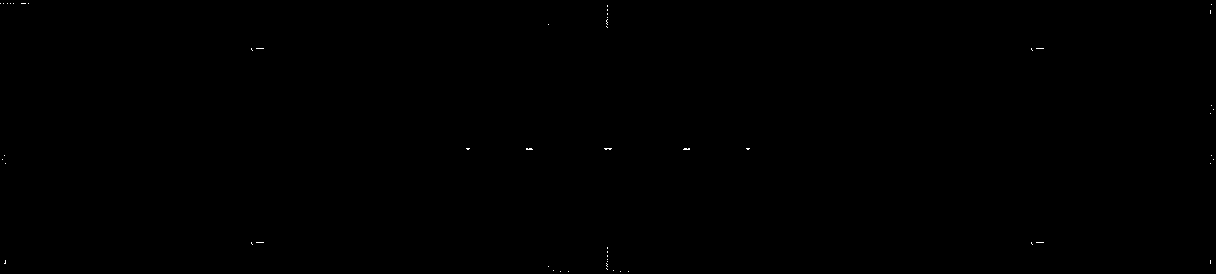

In [3]:
mod = codegen.Module()
cst = codegen.Constraints()

ibufs = [ibuf(mod, cst, p) for p in true_pins]
dffs = [dff(mod, cst, row, col) for row, col in dff_locs]
    

bs, hdr, ftr, posp, config = tiled_fuzzer.run_pnr(mod, cst, {})
bslib.display(None, bs)

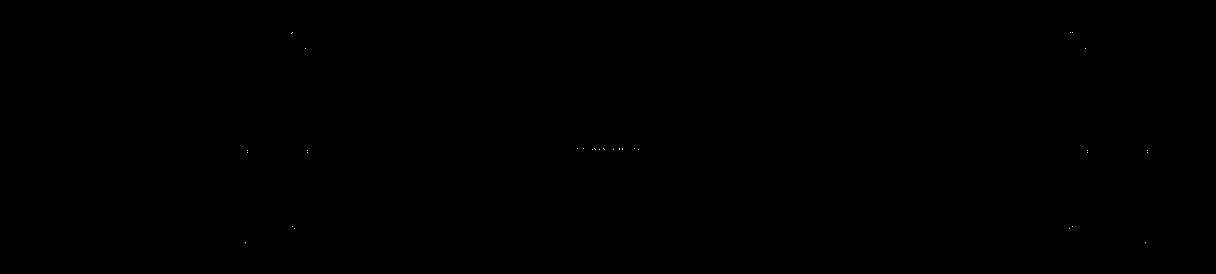

In [4]:
mod.assigns = zip(dffs, ibufs)
bs_clk, hdr, ftr, posp, config = tiled_fuzzer.run_pnr(mod, cst, {})
diff = bs^bs_clk
tiles = fuse_h4x.tile_bitmap(fse, diff)
bslib.display(None, diff)

In [5]:
tiles.keys()

dict_keys([(1, 4, 12), (1, 17, 12), (5, 9, 82), (5, 10, 83), (6, 3, 14), (6, 4, 14), (6, 17, 13), (6, 18, 13), (9, 3, 12), (9, 4, 12), (9, 17, 12), (9, 18, 12)])

dff
(1, 4, 12)


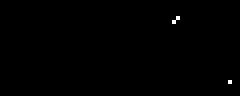

dff
(1, 17, 12)


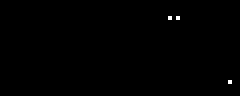

(5, 9, 82)


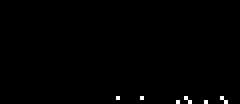

(5, 10, 83)


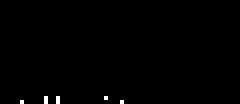

(6, 3, 14)


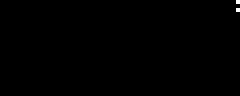

(6, 4, 14)


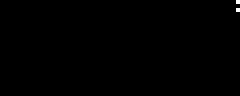

(6, 17, 13)


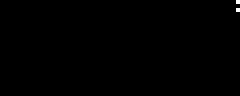

(6, 18, 13)


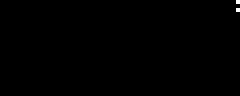

(9, 3, 12)


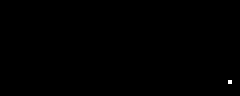

dff
(9, 4, 12)


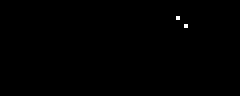

dff
(9, 17, 12)


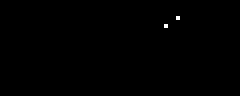

(9, 18, 12)


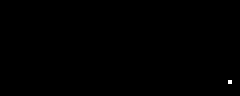

In [6]:
for loc, tile in tiles.items():
    im = bslib.display(None, tile)
    im_scaled = im.resize((im.width*4, im.height*4), Image.NEAREST)
    if (loc[0]+1, loc[1]+1) in dff_locs:
        print('dff')
    print(loc)
    display(im_scaled)

At this point several things are notable.

 * In the DFF that were placed, a few bits in the routing MUXes changed, 99% sure that's just the connection to `GBxx`, which warants confirmation.
 * **No bits in the IOB changed**. This suggests they are by default connected to the clock tree? What if you use the complementary pin?
 * A bunch of bits in the center tile changed, this is probably where the meat of the clock routing happens.
 * In the center row there are a few tiles with 2 bits changed, most likely connecting a horizontal "spine" from the center tile to a vertical "tap".
 * In several tiles there is one bit, most likely connecting the "tap" to a horizontal "branch".
 
This all has to be further explored.

It can be seen that the tiles in which the "spine" is connected to the "taps" are of a distinct type, namely type 13 and 14.

![tile grid](doc/fig/fuse.png)

Meanwhile, looking at the bits within a tile of type 12, it can be seen that the single dots correspond with the bottom right cluster, while the bits of type 13 and 14 are not present. There is an empty column there.

![tile grid](doc/fig/tile.png)

Let's see if tile 13 and 14 indeed have something interesting at these bits.

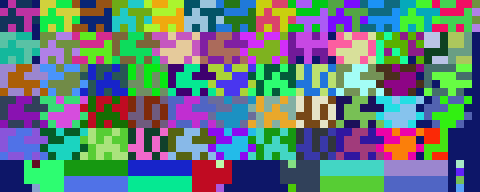

In [7]:
tile = fuse_h4x.render_tile(fse, 14)
im = fuse_h4x.display(None, tile)
im.resize((im.width*8, im.height*8), Image.NEAREST) # THEY DO!

In [8]:
# Lets parse the tile to confirm the MUX
bm = chipdb.tile_bitmap(db, bs_clk)
interesting = {loc[0:2] for loc in tiles.keys()}
for idx, t in bm.items():
    if idx in interesting:
        row, col = idx
        dbtile = db.grid[row][col]
        bels, pips = gowin_unpack.parse_tile_(dbtile, t)
        print(idx, "DFF?", 'DFF0' in bels, "CLK0:", pips['CLK0'], "GBO0:", pips.get('GBO0'))

(1, 4) DFF? True CLK0: GB10 GBO0: GT00
(1, 17) DFF? True CLK0: GB00 GBO0: GT00
(5, 9) DFF? False CLK0: VCC GBO0: None
(5, 10) DFF? False CLK0: VCC GBO0: None
(6, 3) DFF? False CLK0: VCC GBO0: None
(6, 4) DFF? False CLK0: VCC GBO0: None
(6, 17) DFF? False CLK0: VCC GBO0: None
(6, 18) DFF? False CLK0: VCC GBO0: None
(9, 3) DFF? False CLK0: VCC GBO0: GT00
(9, 4) DFF? True CLK0: GB20 GBO0: None
(9, 17) DFF? True CLK0: GB30 GBO0: None
(9, 18) DFF? False CLK0: VCC GBO0: GT00


So this confirms that `CLK0` is indeed connected to `GBxx`, and in fact 4 diffrent `GBxx`.
It also shows that we're already decoding the `GBO0` to `GT00` connection, which I'm 99% sure corresponds to the bottom right bit.
What it all means? Nobody knows. Okay, maybe some god and a few Gowin engineers...

The fact that there is only one `GBO0` to `GT00` connection would suggest it routes all `GBxx` and then selects one locally.
But what's weird is that it seems to route each via a seperate tap, while the DFF are in the same column. Would it then not be more sense to enable one tap for both?
Maybe this is to limit clock skew?

Next step is to dig in the fuse file and confirm the `GBO0` to `GT00` connection and inspect the top right bits in tiles 13 and 14.

In [12]:
spine_tile = tiles[(6, 3, 14)]
#fs = fuse_h4x.scan_fuses(fse, 14, spine_tile)
loc = list(zip(*np.where(spine_tile==1)))
print(loc)
#fuses = fuse_h4x.scan_tables(fse, 14, fs)
#parsed = fuse_h4x.parse_tile(fse, 14, spine_tile)
# stolen from chipdb.py
def fse_pips(fse, ttyp, table):
    pips = {}
    for srcid, destid, *fuses in fse[ttyp]['wire'][table]:
        fuses = {fuse_h4x.fuse_lookup(fse, ttyp, f) for f in chipdb.unpad(fuses)}
        if srcid < 0:
            fuses = set()
            srcid = -srcid
        #if srcid > 1000:
        #    srcid -= 1000 # what does it mean?
        #if destid > 1000:
        #    destid -= 1000 # what does it mean?
        src = wirenames[srcid]
        dest = wirenames[destid]
        pips.setdefault(dest, {})[src] = fuses
    return pips
    
fse_pips(fse, 13, 38)

[(0, 59), (2, 59)]


{'GT00': {'A6': {(0, 59), (2, 59)},
  'B6': {(0, 59), (2, 59)},
  'C6': {(0, 59), (2, 59)},
  'D6': {(0, 59), (2, 59)}},
 'GT10': {'A7': {(1, 59), (3, 59)},
  'B7': {(1, 59), (3, 59)},
  'C7': {(1, 59), (3, 59)},
  'D7': {(1, 59), (3, 59)},
  'N130': {(3, 59)},
  'EW20': {(1, 59), (3, 59)},
  'E130': {(1, 59), (3, 59)},
  'W100': {(1, 59), (3, 59)},
  'W130': {(1, 59)},
  'N200': {(1, 59), (3, 59)},
  'N210': {(1, 59), (3, 59)},
  'N220': {(1, 59), (3, 59)},
  'N230': {(1, 59), (3, 59)}}}

That is... somewhat confusing. But hey, it seems that wire table 38 contains the fuses for the top right bits, which drive `GT00`.
It's worth noting the source wire names might not be accurate, this is after all a completely different wire table.
Normal routing is in table 2.

Note also from `wirenames` that there are just two `GBO0`/`GBO1` and two `GT00`/`GT10`, while there are 8 `GBxx`. (note `O`/`0`).
Does this match with primary/secondary naming in the timing info? Seems plausible.

So okay, I can get into this. *something* drives the vertical `GT00` wires, which drives the horizontal `GBO0` wires, which drives the `GBxx` inputs at th DFF. I think it's time to look at this big and scary center tiles.

In [10]:
print("Wire tables:", list(fse[82]['wire'].keys()), list(fse[83]['wire'].keys())) # table 38 again!
print("Tile 82 destinations:", list(fse_pips(fse, 82, 38).keys()))
print("Tile 14 source:      ", [list(k.keys()) for k in fse_pips(fse, 14, 38).values()])
print("Tile 83 destinations:", list(fse_pips(fse, 83, 38).keys()))
print("Tile 13 source:      ", [list(k.keys()) for k in fse_pips(fse, 13, 38).values()])

Wire tables: [2, 38] [2, 38]
Tile 82 destinations: ['A4', 'B4', 'C4', 'D4', 'A5', 'B5', 'N100', 'SN10', 'SN20', 'N130', 'F0', 'F1', 'F6', 'F2', 'F3', 'F4', 'F5']
Tile 14 source:       [['A4', 'B4', 'C4', 'D4'], ['A5', 'B5', 'C5', 'D5', 'N100', 'SN10', 'SN20', 'N130', 'S100', 'S130', 'E100', 'EW10']]
Tile 83 destinations: ['A6', 'B6', 'C6', 'D6', 'A7', 'B7', 'EW20', 'E130', 'W100', 'W130', 'Q0', 'Q1', 'Q6', 'Q2', 'Q3', 'Q4', 'Q5']
Tile 13 source:       [['A6', 'B6', 'C6', 'D6'], ['A7', 'B7', 'C7', 'D7', 'N130', 'EW20', 'E130', 'W100', 'W130', 'N200', 'N210', 'N220', 'N230']]


This is interesting, it appears that despite the awkward names, most of the routes actually match. The puzzling part is the sources of the center tiles.
Somehow these have to match up with dedicated clock pins and other clock sources.
If the taps and branches indeed switch all 8 global clocks at once, there should be a bunch of different muxes in there.
How is this encoded in the fuse file? No idea. More poking around needed...

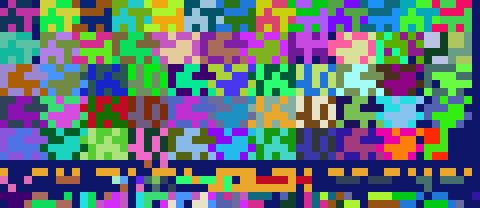

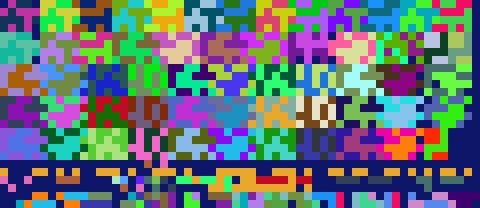

In [26]:
tile = fuse_h4x.render_tile(fse, 83)
im = fuse_h4x.display(None, tile)
display(im.resize((im.width*8, im.height*8), Image.NEAREST))

im = bslib.display(None, tiles[(5, 10, 83)][-2:,:])
display(im.resize((im.width*8, im.height*8), Image.NEAREST))

tile = fuse_h4x.render_tile(fse, 82)
im = fuse_h4x.display(None, tile)
display(im.resize((im.width*8, im.height*8), Image.NEAREST))

im = bslib.display(None, tiles[(5, 9, 82)][-2:,:])
display(im.resize((im.width*8, im.height*8), Image.NEAREST))